In [39]:
import numpy as np
from aicspylibczi import CziFile
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.color import rgb2lab
from skimage import measure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import tifffile as tf
import os

In [4]:
pth = Path('\\\\mfad\\researchmn\\HCPR\\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\\Archive\\WSI_czi\\OvarianTMA_Goode_H&E.czi')
czi = CziFile(pth)

# Get the shape of the data, the coordinate pairs are (start index, size)
dimensions = czi.get_dims_shape()
dims = czi.dims
size = czi.size


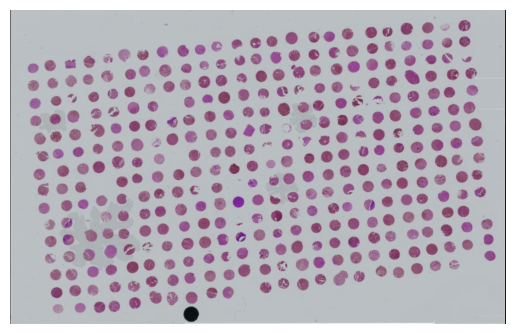

In [8]:
'''
# get and show the entire whole slide image thumbnail
'''
scale = 128
thumbnail = czi.read_mosaic(C=0, scale_factor=1/scale)  # downsampling rate set to 128
#img = np.swapaxes(thumbnail, 0, 1)  # swap the color channels, otherwise the looking is incorrect.
#rgb_thumbnail_img = np.swapaxes(img, 1, 2)
#plt.imshow(rgb_thumbnail_img)
# plt.imshow(img)
rgb_thumbnail_img = np.squeeze(thumbnail)
plt.imshow(rgb_thumbnail_img)
plt.axis("off")
plt.show()

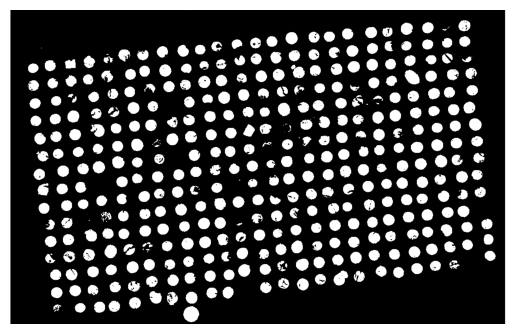

In [12]:
# detect tissues from thumbnails
lab_thumbnail_img = rgb2lab(rgb_thumbnail_img)
l_img = lab_thumbnail_img[:, :, 0]
# plt.hist(np.array(l_img).flatten())
# plt.show()

b_i = l_img < 60
threshold_img = np.array(b_i).astype(np.uint8)*255
plt.imshow(threshold_img, cmap="gray")
plt.axis("off")
plt.show()



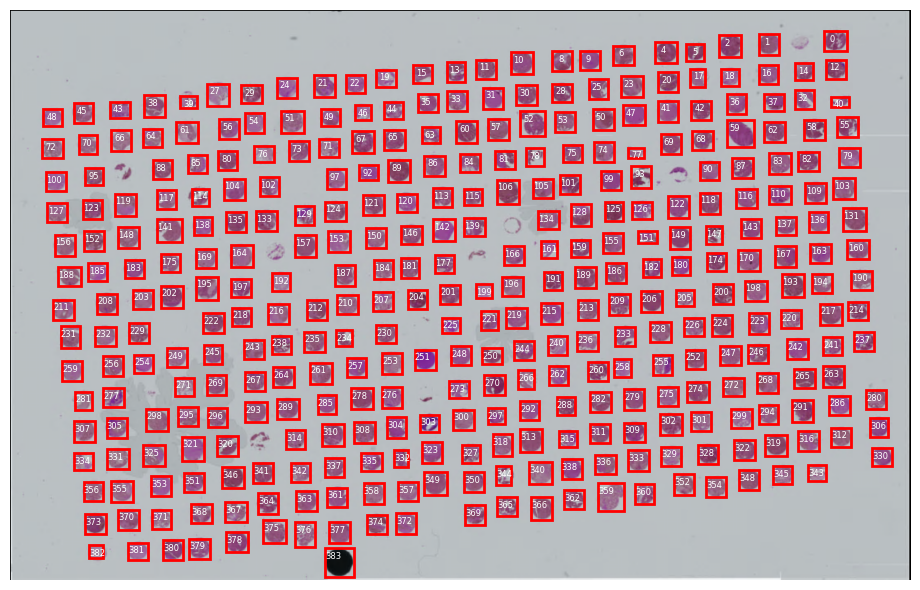

In [49]:
tissue_size = 3250
tissue_thumbnail_diameter = tissue_size/scale # tissue circle diameter
tissue_thumbnail_area_filter = tissue_thumbnail_diameter**2 * 0.2  # if the tissue area is less than 20%, filter those out

bw = closing(b_i, square(3))
cleared = clear_border(bw)
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=rgb_thumbnail_img, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)
ax.imshow(rgb_thumbnail_img)
rect_list = []
for idx, region in enumerate(regionprops(label_image)):
    # take regions with large enough areas
    if region.area >= tissue_thumbnail_area_filter:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect_list.append([minr, minc, maxr, maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_artist(rect)
        ax.annotate('%d' %idx, (minc+10, minr+10), color='w',
                fontsize=6, ha='center', va='center')


ax.set_axis_off()
plt.tight_layout()

save_to_fn = r"\\mfad\researchmn\HCPR\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\Archive\WSI_czi\MxIF_cor_vHE\FOV_ids.png"
plt.savefig(save_to_fn, dpi=300)

plt.show()

In [17]:
print("number of detected FOVs: %d" % len(rect_list))

number of detected FOVs: 345


<Figure size 640x480 with 0 Axes>

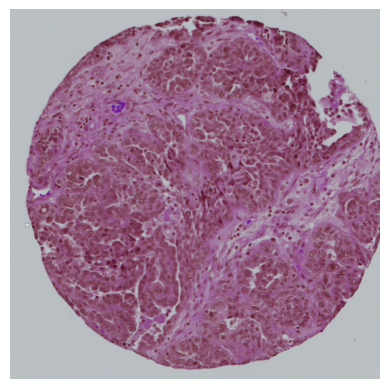

In [30]:
'''
# get the a rectangle region from whole slide image
'''
bbox = czi.get_scene_bounding_box()  # get the initial offset
rect_x = 9550   # top left coordinate of the rectangle region
rect_y = 14300
rect_w = 3250   # each TMA tissue has width in 3250 pixels
rect_h = 3250   # height
# please note that the region you would like to extract should add the initial offset
mosaic_data = czi.read_mosaic(C=0, region=(bbox.x+rect_x, bbox.y+rect_y, rect_w, rect_h), scale_factor=1.0)
shape = mosaic_data.shape

plt.imshow(np.squeeze(mosaic_data))
plt.axis("off")
plt.show()

In [41]:
count = 0
out_dir = r"\\mfad\researchmn\HCPR\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\Archive\WSI_czi\HE_FOVs"
for minr, minc, maxr, maxc in rect_list:
    w = scale*(maxc - minc)
    h = scale*(maxr - minr)
    x = bbox.x+minc*scale
    y = bbox.y+minr*scale
    img_reg = czi.read_mosaic(C=0, region=(x, y, w, h), scale_factor=1.0)
    rgb_img = np.squeeze(img_reg)
    # if count == 15:
    #     plt.imshow(rgb_img)
    #     plt.axis("off")
    #     plt.show()
    #     break

    fn = os.path.join(out_dir, "FOV%d_%d_%d_%d_%d.tif" % (count, x, y, w, h))
    count += 1
    tf.imwrite(fn, rgb_img)